In [2]:
from google.colab import files

# Upload both zip files when prompted
uploaded = files.upload()


Saving archive (3).zip to archive (3).zip


In [3]:
import zipfile
import os

# Unzip the dataset
zip_path = '/content/sandp.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [4]:
# Check the contents
os.listdir('/content/')


['.config',
 '.ipynb_checkpoints',
 'Noisy_folder',
 'Ground_truth',
 'sandp.zip',
 'sample_data']

In [6]:
import cv2
import numpy as np
import os

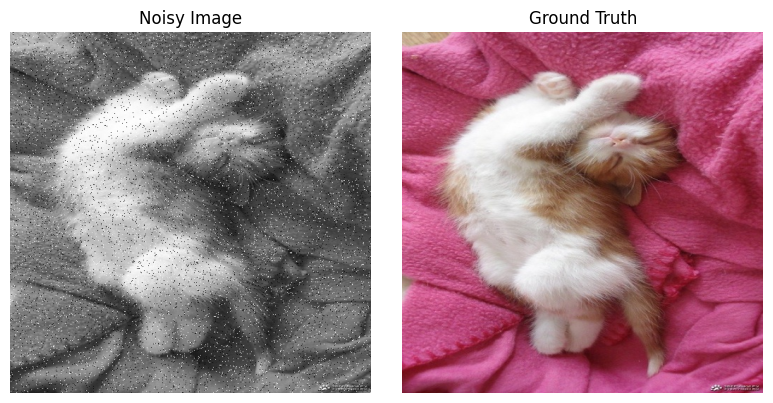

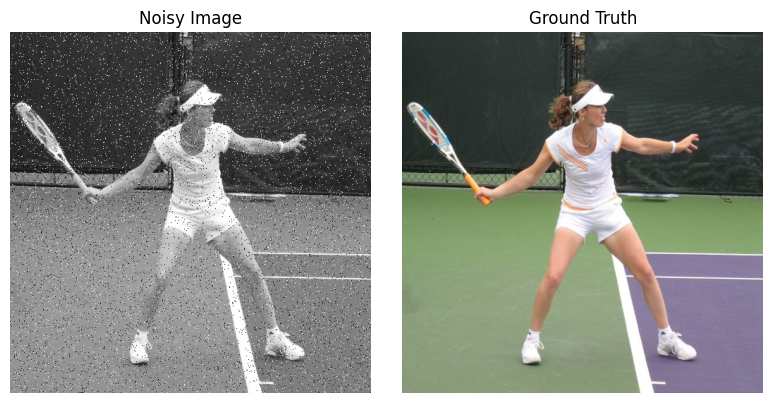

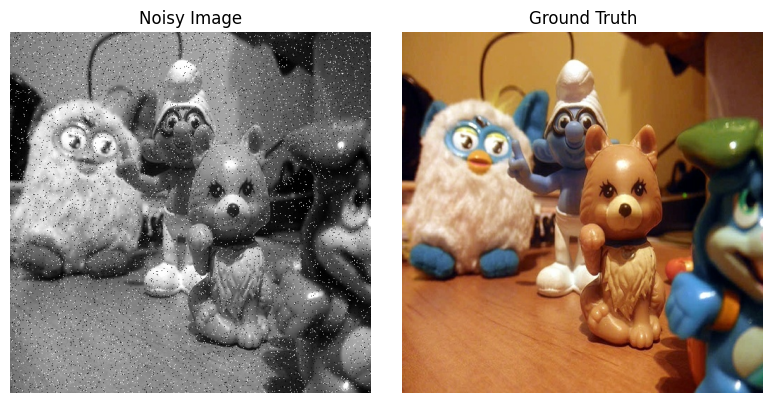

In [9]:
import os
import cv2
import matplotlib.pyplot as plt

noisy_dir = '/content/Noisy_folder'
gt_dir = '/content/Ground_truth'

# Get sorted list of files
noisy_files = sorted(os.listdir(noisy_dir))
gt_files = sorted(os.listdir(gt_dir))

# View a few image pairs (adjust range if needed)
for i in range(3):
    noisy_img_path = os.path.join(noisy_dir, noisy_files[i])
    gt_img_path = os.path.join(gt_dir, gt_files[i])

    # Read images
    noisy = cv2.imread(noisy_img_path, cv2.IMREAD_GRAYSCALE)
    gt = cv2.imread(gt_img_path)

    # Convert to RGB for visualization
    noisy_rgb = cv2.cvtColor(noisy, cv2.COLOR_GRAY2RGB)
    gt_rgb = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)

    # Plot
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(noisy_rgb)
    plt.title("Noisy Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(gt_rgb)
    plt.title("Ground Truth")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [17]:
import os

print("Files in Noisy_folder:")
print(sorted(os.listdir('/content/Noisy_folder'))[:5])

print("\nFiles in Ground_truth:")
print(sorted(os.listdir('/content/Ground_truth'))[:5])


Files in Noisy_folder:
['noisy_10961455225_0786d3edd2_c.jpg', 'noisy_1110822219_a079aeff30_c.jpg', 'noisy_11905744206_c9273e7489_c.jpg', 'noisy_11957512115_382fbccc03_c.jpg', 'noisy_127215712_ff5b654d07_c.jpg']

Files in Ground_truth:
['10961455225_0786d3edd2_c.jpg', '1110822219_a079aeff30_c.jpg', '11905744206_c9273e7489_c.jpg', '11957512115_382fbccc03_c.jpg', '127215712_ff5b654d07_c.jpg']


In [16]:
def load_image_pairs(noisy_dir, clean_dir, img_size):
    noisy_imgs = []
    clean_imgs = []

    filenames = sorted(os.listdir(noisy_dir))
    for file in filenames:
        # Strip "noisy_" prefix for matching clean image
        clean_filename = file.replace("noisy_", "")

        noisy_path = os.path.join(noisy_dir, file)
        clean_path = os.path.join(clean_dir, clean_filename)

        noisy_img = cv2.imread(noisy_path, cv2.IMREAD_GRAYSCALE)
        clean_img = cv2.imread(clean_path)

        if noisy_img is None or clean_img is None:
            print(f"Skipping {file} (not found or corrupted)")
            continue

        # Resize and convert
        noisy_img = cv2.resize(noisy_img, (img_size, img_size))
        noisy_img = cv2.cvtColor(noisy_img, cv2.COLOR_GRAY2RGB)

        clean_img = cv2.resize(clean_img, (img_size, img_size))
        clean_img = cv2.cvtColor(clean_img, cv2.COLOR_BGR2RGB)

        # Normalize
        noisy_imgs.append(noisy_img.astype(np.float32) / 255.0)
        clean_imgs.append(clean_img.astype(np.float32) / 255.0)

    return np.array(noisy_imgs), np.array(clean_imgs)

noisy_dir = '/content/Noisy_folder'
clean_dir = '/content/Ground_truth'
IMG_SIZE = 128

X_noisy, X_clean = load_image_pairs(noisy_dir, clean_dir, IMG_SIZE)
print("Loaded Noisy:", X_noisy.shape)
print("Loaded Clean:", X_clean.shape)



Loaded Noisy: (300, 128, 128, 3)
Loaded Clean: (300, 128, 128, 3)


In [18]:
from sklearn.model_selection import train_test_split

X_train_noisy, X_val_noisy, X_train_clean, X_val_clean = train_test_split(
    X_noisy, X_clean, test_size=0.1, random_state=42
)

print("Train set:", X_train_noisy.shape)
print("Validation set:", X_val_noisy.shape)


Train set: (270, 128, 128, 3)
Validation set: (30, 128, 128, 3)


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

In [20]:


def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(input_img, decoded)

# Build and compile the model
autoencoder = build_autoencoder((128, 128, 3))
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history = autoencoder.fit(
    X_train_noisy, X_train_clean,
    epochs=100,
    batch_size=16,
    shuffle=True,
    validation_data=(X_val_noisy, X_val_clean)
)


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0153 - val_loss: 0.0156
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0158 - val_loss: 0.0155
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0144 - val_loss: 0.0155
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0148 - val_loss: 0.0153
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0152 - val_loss: 0.0154
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0153 - val_loss: 0.0156
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0170 - val_loss: 0.0151
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0147 - val_loss: 0.0153
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0150 - val_loss: 0.0152
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0144 - val_loss: 0.0151
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0150 - val_loss: 0.0150
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

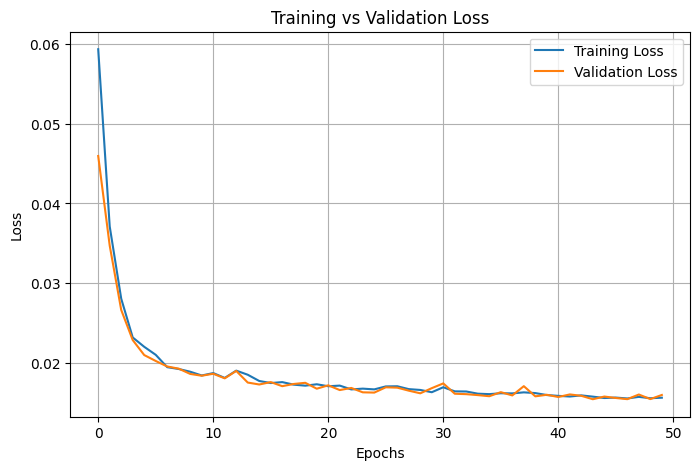

In [22]:
import matplotlib.pyplot as plt

# Plot loss curves
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


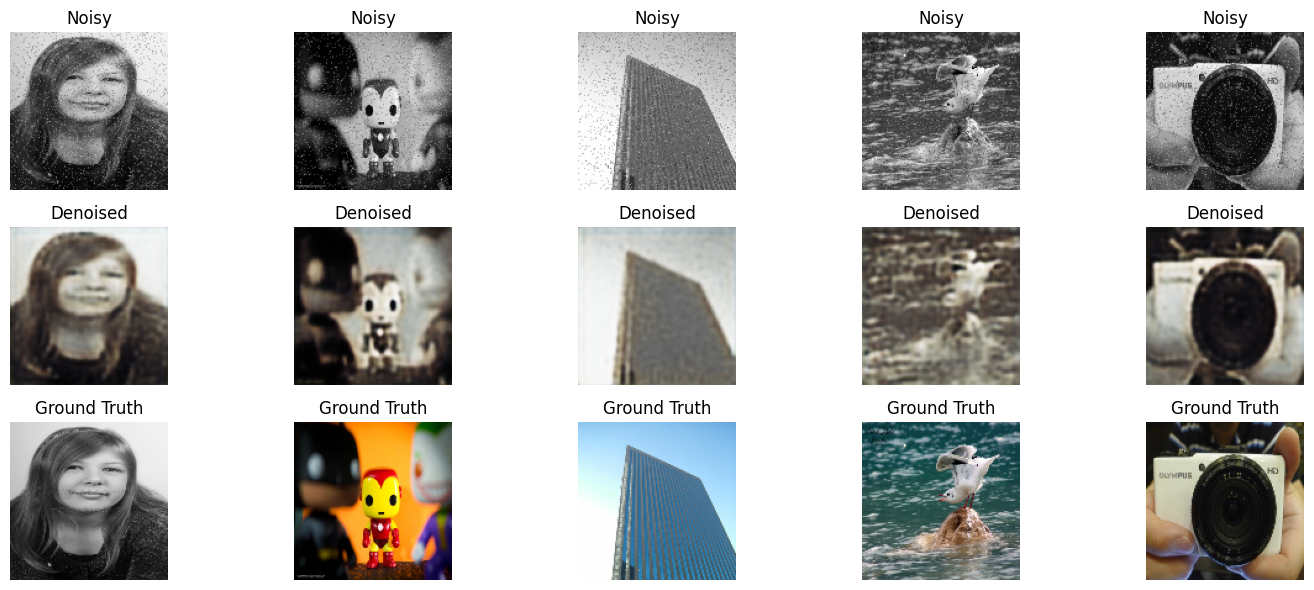

In [23]:
# Predict on validation set
preds = autoencoder.predict(X_val_noisy[:5])

# Plot the results
n = 5  # number of samples to display
plt.figure(figsize=(15, 6))
for i in range(n):
    # Noisy
    plt.subplot(3, n, i+1)
    plt.imshow(X_val_noisy[i])
    plt.title("Noisy")
    plt.axis('off')

    # Denoised (Predicted)
    plt.subplot(3, n, i+1+n)
    plt.imshow(preds[i])
    plt.title("Denoised")
    plt.axis('off')

    # Ground Truth
    plt.subplot(3, n, i+1+2*n)
    plt.imshow(X_val_clean[i])
    plt.title("Ground Truth")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [27]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np

def evaluate_denoising_metrics(gt_images, denoised_images):
    psnr_total = 0
    ssim_total = 0
    mse_total = 0
    count = len(gt_images)

    for gt, denoised in zip(gt_images, denoised_images):
        gt_uint8 = (gt * 255).astype('uint8')
        dn_uint8 = (denoised * 255).astype('uint8')

        # Metrics
        psnr_val = psnr(gt_uint8, dn_uint8, data_range=255)
        ssim_val = ssim(gt_uint8, dn_uint8, data_range=255, channel_axis=-1)  # ✅ Fix here
        mse_val = np.mean((gt - denoised) ** 2)

        psnr_total += psnr_val
        ssim_total += ssim_val
        mse_total += mse_val

    return {
        "Average PSNR": psnr_total / count,
        "Average SSIM": ssim_total / count,
        "Average MSE": mse_total / count
    }


In [28]:
preds = autoencoder.predict(X_val_noisy)
metrics = evaluate_denoising_metrics(X_val_clean, preds)

print(f"✅ Average PSNR: {metrics['Average PSNR']:.2f} dB")
print(f"✅ Average SSIM: {metrics['Average SSIM']:.4f}")
print(f"✅ Average MSE: {metrics['Average MSE']:.6f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
✅ Average PSNR: 19.33 dB
✅ Average SSIM: 0.6995
✅ Average MSE: 0.014276


In [29]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def build_unet_denoiser(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    b = Conv2D(256, (3, 3), activation='relu', padding='same')(b)

    # Decoder
    u1 = UpSampling2D((2, 2))(b)
    u1 = concatenate([u1, c2])
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    u2 = UpSampling2D((2, 2))(c3)
    u2 = concatenate([u2, c1])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c4)

    return Model(inputs, outputs)


In [30]:
unet_autoencoder = build_unet_denoiser(input_shape=(128, 128, 3))
unet_autoencoder.compile(optimizer='adam', loss='mean_squared_error')
unet_autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 64)     │              0 │ conv2d_6[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 32, 32, 128)    │              0 │ conv2d_8[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_2           │ (None, 64, 64, 256)    │              0 │ conv2d_10[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 384)    │              0 │ up_sampling2d_2[0][0], │
│                           │                        │                │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 64, 64, 128)    │        442,496 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_3           │ (None, 128, 128, 128)  │              0 │ conv2d_12[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 128, 128, 192)  │              0 │ up_sampling2d_3[0][0], │
│ (Concatenate)             │                        │                │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 128, 128, 64)   │        110,656 │ concatenate_1[0][0]    │
├──────────────────────

 Total params: 1,883,267 (7.18 MB)

 Trainable params: 1,883,267 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history = unet_autoencoder.fit(
    X_train_noisy, X_train_clean,
    epochs=100,
    batch_size=16,
    validation_data=(X_val_noisy, X_val_clean),
    shuffle=True
)


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 0.0743 - val_loss: 0.0498
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 0.0388 - val_loss: 0.0234
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0209 - val_loss: 0.0168
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0165 - val_loss: 0.0157
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 0.0144 - val_loss: 0.0146
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0149 - val_loss: 0.0141
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0153 - val_loss: 0.0165
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 0.0148 - val_loss: 0.0138
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 0.0136 - val_loss: 0.0131
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.0131 - val_loss: 0.0129
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0125 - val_loss: 0.0127
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


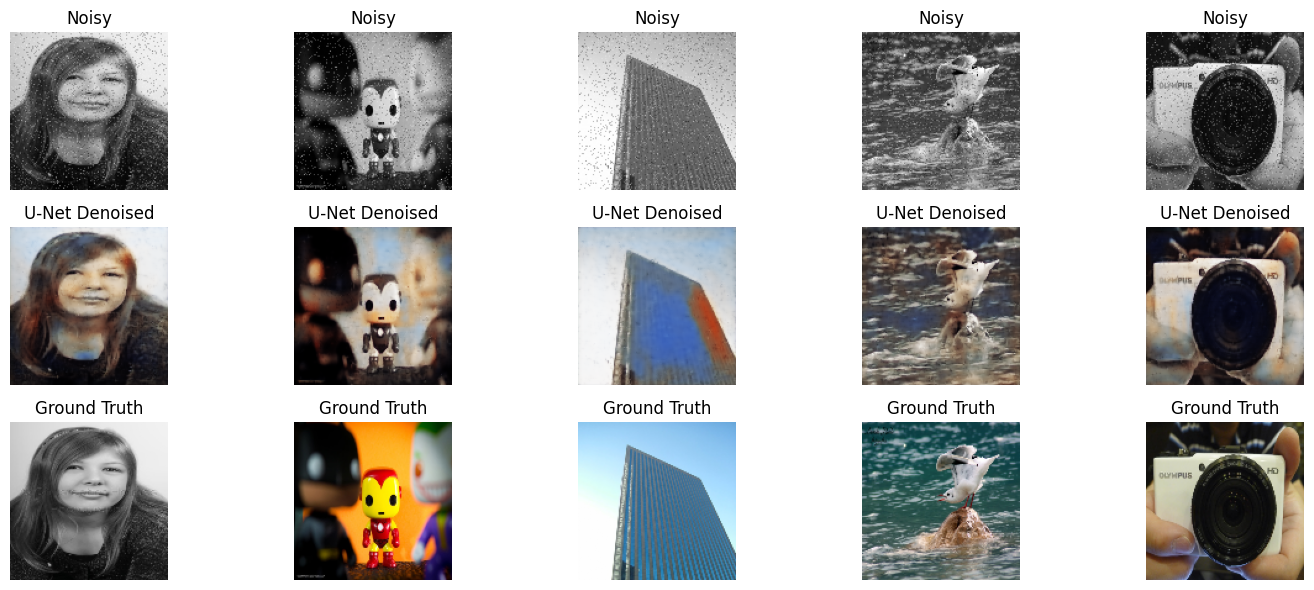

In [32]:
import matplotlib.pyplot as plt

# Predict a few examples using U-Net model
preds_unet = unet_autoencoder.predict(X_val_noisy[:5])

# Show comparisons
n = 5  # number of samples
plt.figure(figsize=(15, 6))
for i in range(n):
    # Noisy
    plt.subplot(3, n, i+1)
    plt.imshow(X_val_noisy[i])
    plt.title("Noisy")
    plt.axis('off')

    # Denoised
    plt.subplot(3, n, i+1+n)
    plt.imshow(preds_unet[i])
    plt.title("U-Net Denoised")
    plt.axis('off')

    # Ground Truth
    plt.subplot(3, n, i+1+2*n)
    plt.imshow(X_val_clean[i])
    plt.title("Ground Truth")
    plt.axis('off')

plt.tight_layout()
plt.show()


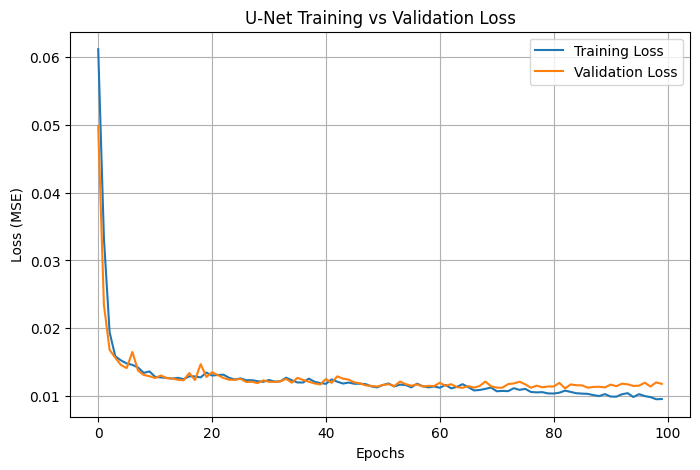

In [33]:
# Plot training vs validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("U-Net Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [34]:
preds_unet = unet_autoencoder.predict(X_val_noisy)
metrics_unet = evaluate_denoising_metrics(X_val_clean, preds_unet)

print(f"✅ [U-Net] Average PSNR: {metrics_unet['Average PSNR']:.2f} dB")
print(f"✅ [U-Net] Average SSIM: {metrics_unet['Average SSIM']:.4f}")
print(f"✅ [U-Net] Average MSE: {metrics_unet['Average MSE']:.6f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
✅ [U-Net] Average PSNR: 20.30 dB
✅ [U-Net] Average SSIM: 0.7907
✅ [U-Net] Average MSE: 0.011804
